In [5]:
# ============================================
# 1. Importy
# ============================================
import numpy as np
import pandas as pd
import yfinance as yf
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
import matplotlib.pyplot as plt

In [6]:
import numpy as np
from src.utils import load_data

df_raw_AAPL = load_data('AAPL', '2009-01-01', '2025-01-01')
df_train_AAPL = df_raw_AAPL[df_raw_AAPL.index <= '2023-01-01']
df_test_AAPL = df_raw_AAPL[df_raw_AAPL.index > '2023-01-01']

df_raw_META = load_data('META', '2009-01-01', '2025-01-01')
df_train_META = df_raw_META[df_raw_META.index <= '2023-01-01']
df_test_META = df_raw_META[df_raw_META.index > '2023-01-01']

df_raw_MSFT = load_data('MSFT', '2009-01-01', '2025-01-01')
df_train_MSFT = df_raw_MSFT[df_raw_MSFT.index <= '2023-01-01']
df_test_MSFT = df_raw_MSFT[df_raw_MSFT.index > '2023-01-01']

df_raw_GOOG = load_data('GOOG', '2009-01-01', '2025-01-01')
df_train_GOOG = df_raw_GOOG[df_raw_GOOG.index <= '2023-01-01']
df_test_GOOG = df_raw_GOOG[df_raw_GOOG.index > '2023-01-01']

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df, max_ep_steps=None, mode="train"):
        super().__init__()

        self.df = df.reset_index(drop=True).astype(float).dropna()
        self.n_steps = len(self.df)

        self.transaction_cost = 0.0025
        self.leverage = 2

        self.mode = mode
        self.max_ep_steps = max_ep_steps  # jeśli None → pełny epizod

        # Feature'y
        self.feature_columns = [
            'Open','High','Low','Close','Volume',
            'Dividends','Stock Splits',
            'roc_20',
            'ema_20','ema_50','ema_20_over_50',
            'sma_5','sma_20','sma_5_over_20',
            'ret_1d','ret_std_30',
            'atr_14','atr_pct',
            'sharpe_20','adx_14',
            'rsi_14',
            'macd','macd_signal','macd_hist',
            'bb_low','bb_mid','bb_up','close_bb_pos'
        ]

        obs_dim = len(self.feature_columns) + 1

        self.observation_space = spaces.Box(
            low=-5, high=5, shape=(obs_dim,), dtype=np.float32
        )

        self.action_space = spaces.Discrete(3)  # 0=flat, 1=long, 2=short

        self.reset()

    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        feat = row[self.feature_columns].values.astype(np.float32)
        return np.append(feat, [float(self.position)])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 1
        self.start_step = 1

        self.position = 0
        return self._get_obs(), {}

    def step(self, action):
        done = False

        price_now = self.df.iloc[self.current_step]["Close"]
        price_prev = self.df.iloc[self.current_step - 1]["Close"]
        step_return = np.log(price_now / price_prev)

        old_pos = self.position

        # akcja
        if action == 0:
            new_pos = 0
        elif action == 1:
            new_pos = 1
        else:
            new_pos = -1

        # reward z poprzedniej pozycji
        reward = old_pos * step_return

        # koszt zmiany pozycji
        if new_pos != old_pos:
            reward -= self.transaction_cost

        # lewar
        reward *= self.leverage

        self.position = new_pos

        self.current_step += 1

        # koniec epizodu
        if self.max_ep_steps is None:
            done = (self.current_step >= self.n_steps - 1)
        else:
            done = (self.current_step - self.start_step >= self.max_ep_steps)

        return self._get_obs(), reward, done, False, {}

    def render(self):
        pass


In [291]:
env_AAPL = TradingEnv(df_train_AAPL)
env_AAPL = Monitor(env_AAPL)

eval_env_AAPL = TradingEnv(df_test_AAPL)
eval_env_AAPL = Monitor(eval_env_AAPL)

env_META = TradingEnv(df_train_META)
env_META = Monitor(env_META)

eval_env_META = TradingEnv(df_test_META)
eval_env_META = Monitor(eval_env_META)

env_MSFT = TradingEnv(df_train_MSFT)
env_MSFT = Monitor(env_MSFT)

eval_env_MSFT = TradingEnv(df_test_MSFT)
eval_env_MSFT = Monitor(eval_env_MSFT)

env_GOOG = TradingEnv(df_train_GOOG)
env_GOOG = Monitor(env_GOOG)

eval_env_GOOG = TradingEnv(df_test_GOOG)
eval_env_GOOG = Monitor(eval_env_GOOG)

In [292]:
policy_kwargs = dict(net_arch=[256, 128])

model_AAPL = DQN(
    policy="MlpPolicy",
    env=env_AAPL,
    learning_rate=3e-4,
    buffer_size=25_000,
    learning_starts=2_000,
    batch_size=128,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=2,
    target_update_interval=2000,
    exploration_fraction=0.5,
    exploration_final_eps=0.1,
    verbose=1
)

model_META = DQN(
    policy="MlpPolicy",
    env=env_META,
    learning_rate=1e-4,
    buffer_size=200_000,
    learning_starts=5_000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    policy_kwargs=policy_kwargs,
)

model_MSFT = DQN(
    policy="MlpPolicy",
    env=env_MSFT,
    learning_rate=1e-4,
    buffer_size=200_000,
    learning_starts=5_000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    policy_kwargs=policy_kwargs,
)

model_GOOG = DQN(
    policy="MlpPolicy",
    env=env_GOOG,
    learning_rate=1e-4,
    buffer_size=200_000,
    learning_starts=5_000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    policy_kwargs=policy_kwargs,
)

Using cpu device
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env in a DummyVecEnv.


In [293]:
eval_callback_AAPL = EvalCallback(
    eval_env_AAPL,
    best_model_save_path="./logs/best_model_AAPL/",
    log_path="./logs/results_AAPL/",
    eval_freq=20_000,
    deterministic=True,
)

eval_callback_META = EvalCallback(
    eval_env_META,
    best_model_save_path="./logs/best_model_META/",
    log_path="./logs/results_META/",
    eval_freq=20_000,
    deterministic=True,
)

eval_callback_MSFT = EvalCallback(
    eval_env_MSFT,
    best_model_save_path="./logs/best_model_MSFT/",
    log_path="./logs/results_MSFT/",
    eval_freq=20_000,
    deterministic=True,
)

eval_callback_GOOG = EvalCallback(
    eval_env_GOOG,
    best_model_save_path="./logs/best_model_GOOG/",
    log_path="./logs/results_GOOG/",
    eval_freq=20_000,
    deterministic=True,
)

checkpoint_callback_AAPL = CheckpointCallback(
    save_freq=50_000,
    save_path="./logs/checkpoints_AAPL/",
    name_prefix="dqn_model",
)

checkpoint_callback_META = CheckpointCallback(
    save_freq=50_000,
    save_path="./logs/checkpoints_META/",
    name_prefix="dqn_model",
)

checkpoint_callback_MSFT = CheckpointCallback(
    save_freq=50_000,
    save_path="./logs/checkpoints_MSFT/",
    name_prefix="dqn_model",
)

checkpoint_callback_GOOG = CheckpointCallback(
    save_freq=50_000,
    save_path="./logs/checkpoints_GOOG/",
    name_prefix="dqn_model",
)

In [294]:
model_AAPL.learn(
    total_timesteps=200_000,
    callback=[eval_callback_AAPL, checkpoint_callback_AAPL],
)

#model_META.learn(
#    total_timesteps=200_000,
#    callback=[eval_callback_META, checkpoint_callback_META],
#)
#
#model_MSFT.learn(
#    total_timesteps=200_000,
#    callback=[eval_callback_MSFT, checkpoint_callback_MSFT],
#)
#
#model_GOOG.learn(
#    total_timesteps=200_000,
#    callback=[eval_callback_GOOG, checkpoint_callback_GOOG],
#)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.46e+03 |
|    ep_rew_mean      | -8.89    |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 322      |
|    time_elapsed     | 42       |
|    total_timesteps  | 13836    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.000629 |
|    n_updates        | 23670    |
----------------------------------
Eval num_timesteps=20000, episode_reward=-0.11 +/- 0.00
Episode length: 530.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 530      |
|    mean_reward      | -0.11    |
| rollout/            |          |
|    exploration_rate | 0.82     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.000491 |
| 

In [295]:
import numpy as np

data = np.load("logs/results_AAPL/evaluations.npz")
timesteps = data["timesteps"]
results = data["results"]  # shape: (n_evals, n_eval_episodes)

mean_rewards = results.mean(axis=1)

best_idx = mean_rewards.argmax()
print("Best timestep:", timesteps[best_idx])
print("Best reward:", mean_rewards[best_idx])

Best timestep: 40000
Best reward: 1.118983


In [18]:
from stable_baselines3 import DQN

best_model = DQN.load("logs/grid_AAPL/run_6/best_model/best_model.zip")

test_env = TradingEnv(df_test_AAPL)
obs, _ = test_env.reset()

position = 0
returns = []

for i in range(1, len(df_test_AAPL)):

    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = test_env.step(action)

    reward /= 2

    # --- prawdziwy log-return ---
    price_now = df_test_AAPL["Close"].iloc[i]
    price_prev = df_test_AAPL["Close"].iloc[i-1]
    daily_ret = np.log(price_now / price_prev)

    # --- REALNE ZAROBKI ---
    returns.append(position * daily_ret)

    # --- aktualizacja pozycji ---
    if action == 0:
        position = 0      # flat
    elif action == 1:
        position = +1     # long
    elif action == 2:
        position = -1     # short
        
    if done:
        break


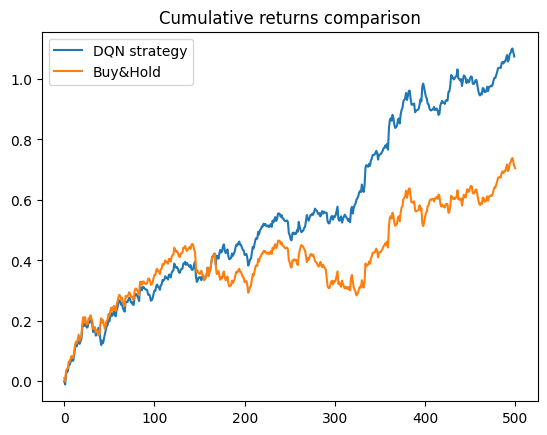

In [19]:
plt.plot(np.cumsum(returns), label="DQN strategy")

close = df_test_AAPL["Close"].values
returns_bh = np.log(close[1:] / close[:-1])
plt.plot(np.cumsum(returns_bh), label="Buy&Hold")

plt.legend()
plt.title("Cumulative returns comparison")
plt.show()


In [17]:
import os
import itertools
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor


# ============================================
# 1. ŚRODOWISKA
# ============================================

# Zakładam, że TradingEnv, df_train_AAPL, df_test_AAPL są już zdefiniowane wcześniej
# np.:
# from trading_env import TradingEnv

def make_train_env():
    return Monitor(TradingEnv(df_train_AAPL))

def make_eval_env():
    return Monitor(TradingEnv(df_test_AAPL))


# ============================================
# 2. SIATKA PARAMETRÓW (GRID)
# ============================================

param_grid = {
    "learning_rate": [5e-4, 3e-4],
    "exploration_fraction": [0.5, 0.7],
    "target_update_interval": [500, 1000],

    # wzmocniony stabilizator Q
    "use_double": [True],
    "dueling": [True],

    # sieć, która działa najlepiej u Ciebie
    "net_arch": [
        [128, 64]
    ]
}



keys, values = zip(*param_grid.items())
all_param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Liczba kombinacji: {len(all_param_combinations)}")


# ============================================
# 3. PĘTLA GRIDSEARCH + LEARN
# ============================================

results = []

base_log_dir = "./logs/grid_AAPL"
os.makedirs(base_log_dir, exist_ok=True)

TOTAL_TIMESTEPS = 100_000
EVAL_FREQ = 10_000  # co ile kroków robić ewaluację


for i, params in enumerate(all_param_combinations, start=1):
    print("\n====================================")
    print(f"=== Start testu {i}/{len(all_param_combinations)} ===")
    print("Parametry:", params)

    # osobne logi dla danej kombinacji
    run_log_dir = os.path.join(base_log_dir, f"run_{i}")
    best_model_dir = os.path.join(run_log_dir, "best_model")
    os.makedirs(run_log_dir, exist_ok=True)

    # nowe envy dla każdej kombinacji (żeby nie mieszać stanów)
    env_AAPL = make_train_env()
    eval_env_AAPL = make_eval_env()

    eval_callback = EvalCallback(
        eval_env_AAPL,
        best_model_save_path=best_model_dir,
        log_path=run_log_dir,
        eval_freq=EVAL_FREQ,
        deterministic=True
    )

    model = DQN(
        policy="MlpPolicy",
        env=env_AAPL,
        learning_rate=params["learning_rate"],
        buffer_size=100000,
        learning_starts=2_000,
        batch_size=128,
        tau=1.0,
        gamma=0.99,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=params["target_update_interval"],
        exploration_fraction=params["exploration_fraction"],
        exploration_final_eps=0.05,
        policy_kwargs=dict(net_arch=params["net_arch"]),
        verbose=0
    )

    # === TRENING (learn) ===
    model.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        callback=eval_callback
    )

    # ============================================
    # 4. Odczyt wyników z EvalCallback
    # ============================================

    eval_file = os.path.join(run_log_dir, "evaluations.npz")
    if not os.path.exists(eval_file):
        print("Brak pliku evaluations.npz dla tej kombinacji – coś poszło nie tak.")
        mean_reward = -np.inf
    else:
        data = np.load(eval_file)
        # data["results"] ma shape (n_evals, n_eval_episodes)
        mean_rewards_over_evals = data["results"].mean(axis=1)
        mean_reward = float(mean_rewards_over_evals.max())

        best_eval_idx = mean_rewards_over_evals.argmax()
        best_timestep = int(data["timesteps"][best_eval_idx])

        print(f"Najlepsza średnia nagroda (po ewaluacjach): {mean_reward}")
        print(f"Osiągnięta przy timesteepie: {best_timestep}")

    results.append({
        "params": params,
        "mean_reward": mean_reward,
        "run_log_dir": run_log_dir
    })


# ============================================
# 5. WYBÓR NAJLEPSZEJ KOMBINACJI
# ============================================

best_result = max(results, key=lambda x: x["mean_reward"])

print("\n####################################")
print("######## NAJLEPSZA KONFIGURACJA ####")
print("####################################")
print("Parametry:")
for k, v in best_result["params"].items():
    print(f"  {k}: {v}")
print(f"\nNajlepsza średnia nagroda: {best_result['mean_reward']}")
print(f"Logi i evaluations: {best_result['run_log_dir']}")
print(f"Najlepszy model zapisany w: {os.path.join(best_result['run_log_dir'], 'best_model')}")


Liczba kombinacji: 8

=== Start testu 1/8 ===
Parametry: {'learning_rate': 0.0005, 'exploration_fraction': 0.5, 'target_update_interval': 500, 'use_double': True, 'dueling': True, 'net_arch': [128, 64]}
Eval num_timesteps=10000, episode_reward=-1.41 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-1.32 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=-0.09 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-0.86 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=1.24 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=0.94 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=-0.32 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=0.66 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num